**MIRI/MRS Pipeline Script applied to Uranus Cubes**

Based heavily on notebooks by Patrick Kavanagh (DIAS, Ireland): https://github.com/PaddyKavanagh/build7.2.1_notebooks/blob/master/MRS_pipeline.ipynb

* Installed from instructions on https://github.com/spacetelescope/jwst
* `conda create -n jwst_test python`
* `conda activate jwst_test`
* `pip install jwst`
* <code>export CRDS_PATH=$HOME/crds_cache</code>
* <code>export CRDS_SERVER_URL=https://jwst-crds.stsci.edu</code>
* Execution of the level 2A, 2B, and 3 pipelines for MRS data in Python.
* `source activate jwst_test` before opening this notebook.

The steps applied are:
* Ramps to slopes pipeline (Detector1Pipeline)
* CALSPEC2 steps and spectral extraction from each dither (Spec2Pipeline)
* Combination of dithers and spectral extraction (Spec3Pipeline)
* Manual conversion of extracted spectra to Jy

In [42]:
# Imports

import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

# set the CRDS_CONTEXT for the correct build (here 0.18.1)
os.environ["CRDS_CONTEXT"] = "jwst_0664.pmap"

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

2021-01-08 20:49:00,814 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



**Set input, output location and source type**

Since we know the simulation is of a point source, we can set the source type metadata to 'POINT' at this stage as that information is used later in spectral extraction. Otherwise, the pipeline will set the default source type for MRS which is 'EXTENDED'

In [9]:
# set input filenames and directory. In this example, the files are located in a folder called 'testdir'

input_dir = 'testdir'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the source type as 'POINT'
for f in input_files:
    with datamodels.MIRIRampModel(f) as dm:
        dm.meta.target.source_type = 'EXTENDED'
        dm.save(os.path.join(input_dir, dm.meta.filename))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

/opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),


Print some information about the input files. We will just look at the first file


In [10]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:

    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t\t Detector\t nInts\t nGrps\t rdPatt\t subAr\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %d\t %s\t %s\t %s\t %s\t %s" % (identifier,detector,nInts,nGroups,readPatt,subArr,channel,band))
        print("\n\n")

    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t Detector\t nInts\t nGrps\t rdPatt\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %d\t %s\t %s\t %s\t %s" % (detector,nInts,nGroups,readPatt,channel,band))
        print("\n\n")

    # fits extension table
    hdulist.info()


/opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ID	 Detector	 nInts	 nGrps	 rdPatt	 chan.	 band
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIFULONG	 10	 10	 FAST	 34	 MEDIUM



Filename: testdir/det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     110   ()      
  1  SCI           1 ImageHDU        49   (1032, 1024, 10, 10)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 1024, 10, 10)   uint8   
  4  ERR           1 ImageHDU        11   (1032, 1024, 10, 10)   float32   
  5  REFOUT        1 ImageHDU        11   (258, 1024, 10, 10)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [528390941B]   


Show the last frame of the first integration for each file


/opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),


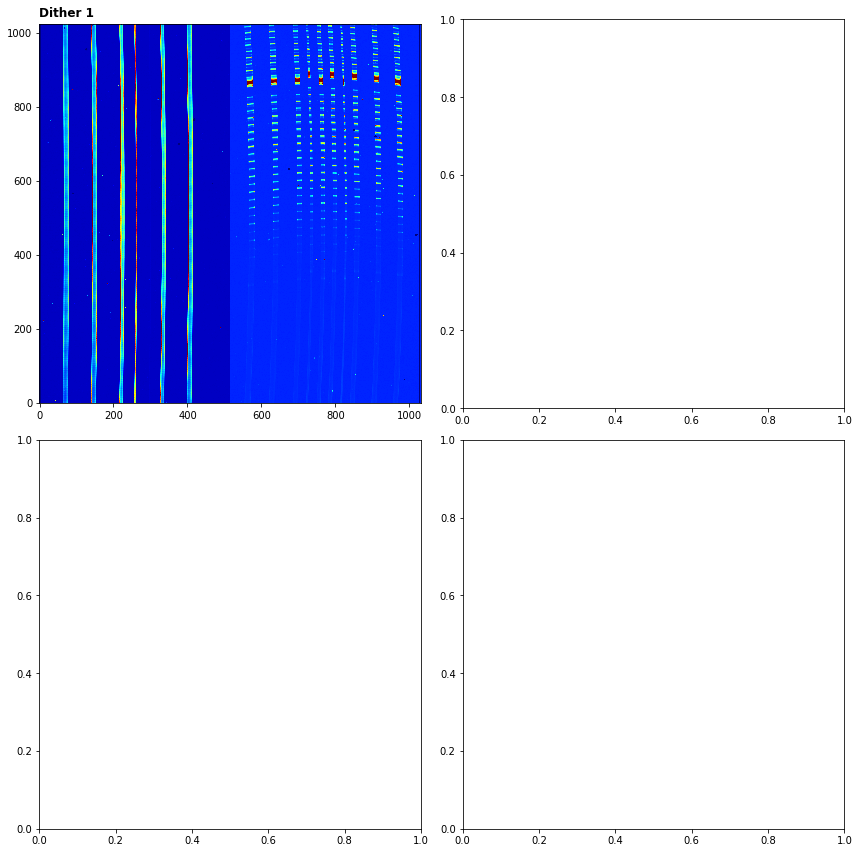

In [11]:

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for f in input_files:
    # open the input image as a jwst data model
    with datamodels.MIRIRampModel(f) as in_dm:

        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.5e4))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

## Level 2A pipeline (ramps-to-slopes)
Import the level 2A pipeline class and print description.
The output level 2A files will be saved in the output_dir as '*_rate.fits'

In [12]:
#LEVEL 2A PIPELINE

from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)

for f in input_files:
    Detector1Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir,
                           steps={'ipc': {'skip': True},
                                  'dark_current': {'skip': True},
                                  'refpix': {'skip': True}})


/opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-01-08 20:18:26,863 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),




    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.
    


2021-01-08 20:18:28,985 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),

2021-01-08 20:18:30,849 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),

2021-01-08 20:18:30,864 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),

2021-01-08 20:18:30,882 - stpipe - WARNING - /opt/anaconda3/envs/jwst_tes

2021-01-08 20:18:31,396 - stpipe.Detector1Pipeline - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),

2021-01-08 20:18:32,574 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits' reftypes = ['gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2021-01-08 20:18:32,581 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2021-01-08 20:18:32,585 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_linearity_0027.fits'.
2021-01-08 20:18:32,586 - stpipe.Detector1Pip

2021-01-08 20:18:41,086 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_linearity_0027.fits
2021-01-08 20:18:42,320 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-01-08 20:18:42,496 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(10, 10, 1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).
2021-01-08 20:18:42,498 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'testdir', 'type': 'baseline'}
2021-01-08 20:18:42,513 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_rscd_0011.fits
2021-01-08 20:18:43,115 - s

2021-01-08 20:21:23,634 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1.fits>,).
2021-01-08 20:21:23,635 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': 'testdir'}
2021-01-08 20:21:23,658 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-01-08 20:21:23,659 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-01-08 20:21:23,660 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-01-08 20:21:23,724 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(10, 1024, 1032) from det_image

In [13]:
# Quick check of the pipeline steps applied in the output. We'll look at the first dither:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('ipc: %s' % dm.meta.cal_step.ipc)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('firstframe: %s' % dm.meta.cal_step.firstframe)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

2021-01-08 20:21:35,325 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
ipc: None
linearity: COMPLETE
rscd: COMPLETE
firstframe: COMPLETE
lastframe: COMPLETE
dark_current: None
refpix: None
jump: COMPLETE
ramp_fit: COMPLETE


## Level 2B pipeline
import the level 2B pipeline class and print description.
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'.
Note that since MIRISim does not add straylight, we can skip the straylight correction step.

The level 2B pipeline for the MRS produces three files for each input:
* _cal.fits - the calibrated level 2B file from each dither
* _s3d.fits - the cube from each dither
* _x1d.fits - the 1d spectrum from each dither

In [14]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)

for f in level2A_files:
    Spec2Pipeline.call(f, output_use_model=True, save_results=True, output_dir=output_dir, 
                       steps={'straylight':{'skip':True}})

2021-01-08 20:21:45,725 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


2021-01-08 20:21:46,092 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2021-01-08 20:21:46,094 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-01-08 20:21:46,097 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-01-08 20:21:46,098 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2021-01-08 20:21:46,099 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2021-01-08 20:21:46,101 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2021-01-08 20:21:46,105 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2021-01-08 20:21:46,107 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.
2021-01-08 20:21:46,109 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.
2021-01-08 20:21:46,112 - stpipe.Spec2Pipeline.master_

2021-01-08 20:21:46,675 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'resol', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2021-01-08 20:21:46,681 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_apcorr_0001.asdf'.
2021-01-08 20:21:46,682 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2021-01-08 20:21:46,683 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2021-01-08 20:21:46,683 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2021-01-08 20:21:46

2021-01-08 20:21:52,417 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).
2021-01-08 20:21:52,419 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': 'testdir_pipelined'}
2021-01-08 20:21:52,419 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2021-01-08 20:21:52,420 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2021-01-08 20:21:52,512 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from det_image_seq1_MIRIFULONG_34MEDIUMexp1_rate.fits>,).
2021-01-08 20:21:52,514 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype param

2021-01-08 20:21:56,399 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2021-01-08 20:21:56,400 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2021-01-08 20:21:56,401 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2021-01-08 20:21:56,402 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting method for point cloud: emsm
2021-01-08 20:21:56,403 - stpipe.Spec2Pipeline.cube_build - INFO - Power weighting distance: 2.0
2021-01-08 20:21:56,426 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']
2021-01-08 20:21:56,427 - stpipe.Spec2Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['medium', 'medium']
2021-01-08 20:21:56,428 - stpipe.Spec2Pipeline.cube_build - INFO - Reading cube parameter file /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_cubepar_0003.fits
2021-01-08 20:21:57,517 - stpipe.Spec2Pipeline.cube_build - INFO - Output I

In [15]:
# check of output

# set the output file names
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))
cube_files = glob.glob(os.path.join(output_dir,'*_s3d.fits'))

with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('srctype: %s' % dm.meta.cal_step.srctype)
    print('straylight: %s' % dm.meta.cal_step.straylight)
    print('fringe: %s' % dm.meta.cal_step.fringe)
    print('photom: %s' % dm.meta.cal_step.photom)

2021-01-08 20:29:55,932 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
srctype: COMPLETE
straylight: None
fringe: COMPLETE
photom: COMPLETE


Look at level 1B and calibrated level 2B image. We'll look at the first dither only.

2021-01-08 20:32:55,443 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2021-01-08 20:32:55,448 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/jwst/lib/basic_utils.py:24: DeprecationWarning: "MIRIRampModel" is deprecated and will be removed. Use RampModel
  warnings.warn(message.format(old_class=old_class.__name__, new_class=new_class.__name__),



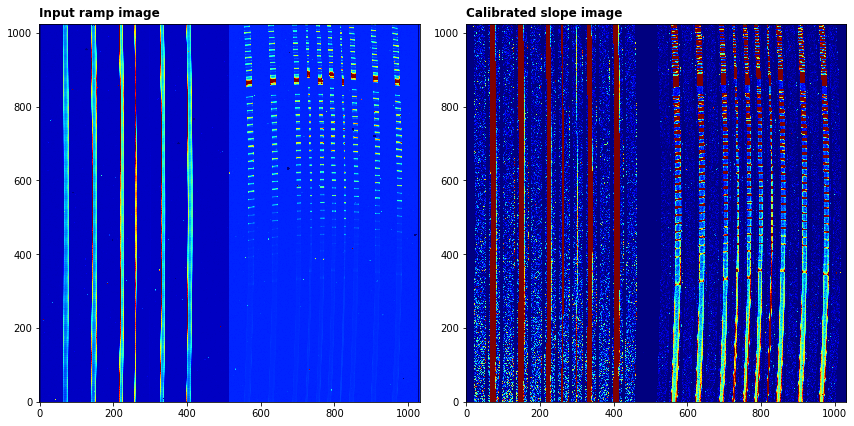

In [28]:
# open the input image as a jwst data model
with datamodels.MIRIRampModel(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1.5e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0, vmax=1000)
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

Look at cube file. We'll look at the first dither only

2021-01-08 20:31:55,877 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



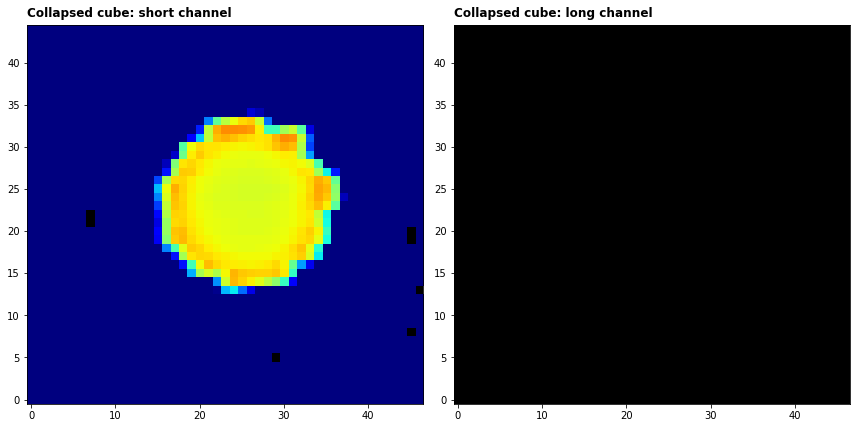

In [26]:
# open the cube as a jwst data model
with datamodels.open(cube_files[0]) as cube_dm:
    
    # plot--------------------------------------
    # sum some of the the frames in each channel
    # Note the user may have to adjust the scaling
    # parameters
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(np.sum(cube_dm.data[100:300], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e5,vmax=1e7))
    axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(np.sum(cube_dm.data[3000:3200], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1,vmax=1e6))
    axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')
    
    plt.tight_layout()
    plt.show()

## Level 3 pipeline
We first create an association file in the output directory containing the list of level 2B files ("_cal.fits") produced by the level 2B pipeline.

Create the level 3 association using the asn_from_list tool

In [29]:
call(["asn_from_list", "-o", "MRS_asn.json"] + level2B_files + ["--product-name", "dither"])


from jwst.pipeline import Spec3Pipeline
print(Spec3Pipeline.__doc__)

# read the association and run
dms = datamodels.open("MRS_asn.json")
Spec3Pipeline.call(dms, save_results=True, output_dir=output_dir,
                  steps={'cube_build': {'save_results': True, 'output_dir': output_dir},
                         'extract_1d': {'save_results': True, 'output_dir': output_dir},
                         'mrs_imatch': {'skip': True}})

2021-01-08 20:33:05,187 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




    Spec3Pipeline: Processes JWST spectroscopic exposures from Level 2b to 3.

    Included steps are:
    assign moving target wcs (assign_mtwcs)
    master background subtraction (master_background)
    MIRI MRS background matching (mrs_imatch)
    outlier detection (outlier_detection)
    2-D spectroscopic resampling (resample_spec)
    3-D spectroscopic resampling (cube_build)
    1-D spectral extraction (extract_1d)
    1-D spectral combination (combine_1d)
    


2021-01-08 20:33:18,774 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2021-01-08 20:33:18,776 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2021-01-08 20:33:18,778 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2021-01-08 20:33:18,779 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2021-01-08 20:33:18,781 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2021-01-08 20:33:18,784 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2021-01-08 20:33:18,786 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2021-01-08 20:33:18,788 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2021-01-08 20:33:18,791 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.
2021-01-08 20:33:19,010 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running

2021-01-08 20:33:19,522 - stpipe.Spec3Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2021-01-08 20:33:19,523 - stpipe.Spec3Pipeline.cube_build - INFO - Input interpolation: pointcloud
2021-01-08 20:33:19,523 - stpipe.Spec3Pipeline.cube_build - INFO - Coordinate system to use: skyalign
2021-01-08 20:33:19,524 - stpipe.Spec3Pipeline.cube_build - INFO - Weighting method for point cloud: emsm
2021-01-08 20:33:19,525 - stpipe.Spec3Pipeline.cube_build - INFO - Power weighting distance: 2.0
2021-01-08 20:33:19,543 - stpipe.Spec3Pipeline.cube_build - INFO - The desired cubes cover the MIRI Channels: ['3', '4']
2021-01-08 20:33:19,544 - stpipe.Spec3Pipeline.cube_build - INFO - The desired cubes cover the MIRI subchannels: ['medium', 'medium']
2021-01-08 20:33:19,544 - stpipe.Spec3Pipeline.cube_build - INFO - Reading cube parameter file /Users/lnf2/crds_cache/references/jwst/miri/jwst_miri_cubepar_0003.fits
2021-01-08 20:33:20,612 - stpipe.Spec3Pipeline.cube_build - INFO - Output C

2021-01-08 20:44:52,752 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



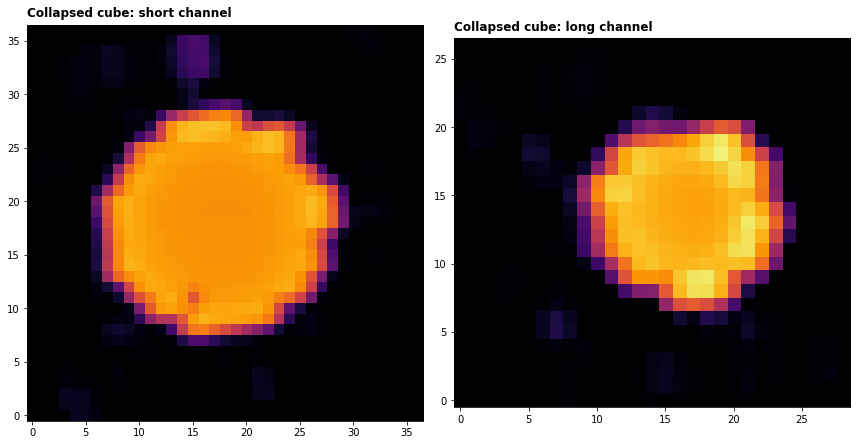

In [37]:
cube_files = sorted(glob.glob(os.path.join(output_dir, 'dither*s3d.fits')))
ch1_cdm = datamodels.open(cube_files[0])
ch2_cdm = datamodels.open(cube_files[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.sum(ch1_cdm.data[100:-100], axis=0), cmap='inferno', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1e7))
axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(np.sum(ch2_cdm.data[100:-100], axis=0), cmap='inferno', interpolation='nearest', origin='lower', norm=LogNorm(vmin=1e4,vmax=1e8))
axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()

2021-01-08 20:52:00,992 - stpipe - WARNING - /opt/anaconda3/envs/jwst_test/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



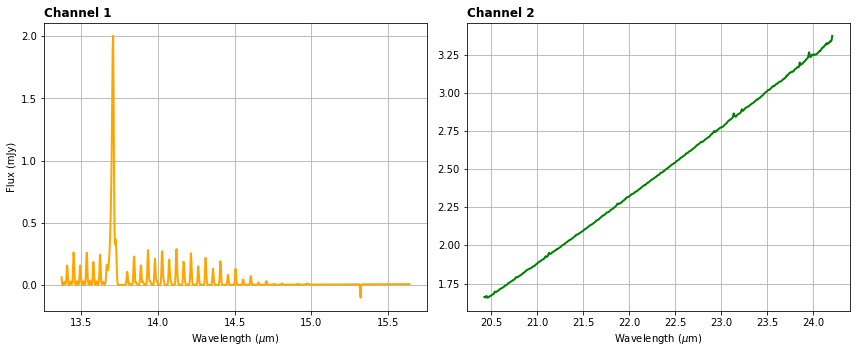

In [52]:
spec_files = sorted(glob.glob(os.path.join(output_dir, 'dither*1d.fits')))
ch1_sdm = datamodels.open(spec_files[0])
ch2_sdm = datamodels.open(spec_files[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot the spectrum in the channel 2 wavelength range
spaxel_area = ch1_cdm.meta.wcsinfo.cdelt1 * ch1_cdm.meta.wcsinfo.cdelt2 * 3600**2
axs[0].plot(ch1_sdm.spec[0].spec_table['WAVELENGTH'], ch1_sdm.spec[0].spec_table['FLUX'] * spaxel_area, c='orange', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[0].set_ylabel(r'Flux (mJy)')
axs[0].set_xlabel(r'Wavelength ($\mu$m)')
#axs[0].set_xlim(4.9,30)
#axs[0].set_ylim(10,200)

spaxel_area = ch2_cdm.meta.wcsinfo.cdelt1 * ch2_cdm.meta.wcsinfo.cdelt2 * 3600**2
axs[1].plot(ch2_sdm.spec[0].spec_table['WAVELENGTH'], ch2_sdm.spec[0].spec_table['FLUX']  * spaxel_area, c='g', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[1].set_xlabel(r'Wavelength ($\mu$m)')
#axs[1].set_xlim(7.5,8.7)

axs[1].annotate('Channel 2', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].annotate('Channel 1', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].grid()
axs[1].grid()

plt.tight_layout()
plt.show()